<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#импорт библиотек и настройка отображения 
!pip install optuna -q

!pip install  phik==0.10.0 -q

!pip install -U scikit-learn -q

# !pip install lightgbm -q 

In [2]:
#импорт библиотек и настройка отображения 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


from sklearn.model_selection import GridSearchCV 

from optuna.integration import OptunaSearchCV
from optuna import distributions

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder

import phik

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.2f}'.format

RANDOM_STATE = 73
TEST_SIZE = 0.25

from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [3]:
# загрузка данных
taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
# посмотрим на содержание
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
print(taxi.info())
print('Дублей: \n', taxi.duplicated().sum())
print('Пустых: \n', taxi.isna().sum())
print('Размер: \n', taxi.size)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
Дублей: 
 26415
Пустых: 
 num_orders    0
dtype: int64
Размер: 
 26496


Данные загружены, столбец с датой/временем приведен в нужный формат, установлены индексы. 

## Анализ

Проверим, в хронологическом ли порядке расположены даты и время.


In [6]:
print(taxi.index.is_monotonic)

True


Индексы расположены в хронологическом порядке. Данные представлены с 01.03.2018 по 31.08.2018 с шагом в 10 минут.

Приведем данные к шагу 1 час.

In [7]:
taxi = taxi.resample('1H').sum()
taxi.head()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
taxi.shape

(4416, 1)

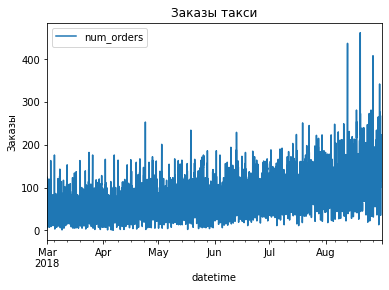

In [9]:
#посмтроим график заказов такси
plt.title('Заказы такси')
plt.ylabel('Заказы')
taxi.plot(ax=plt.gca())
plt.show();

In [10]:
#выделим тренды и сезонность 
decomposed = seasonal_decompose(taxi['num_orders'])

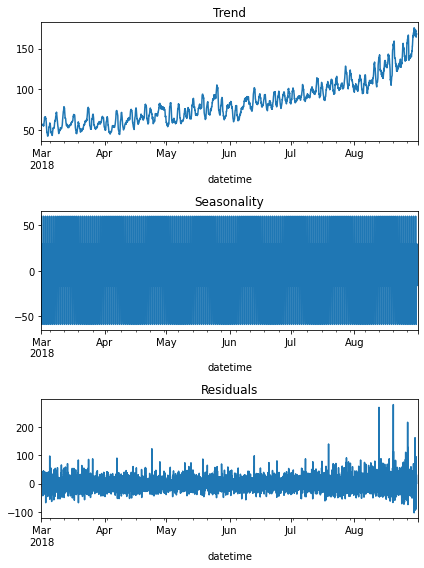

In [11]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График сезонности непонятный. попробуем взять данные за меньший период:
1. За месяц;
2. За неделю. В качестве тестовой недели возьмем неделю марта без праздников (12-18.03);
3. За день.

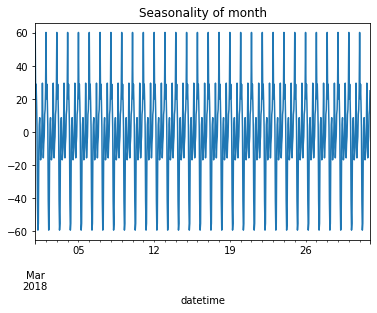

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Seasonality of month');

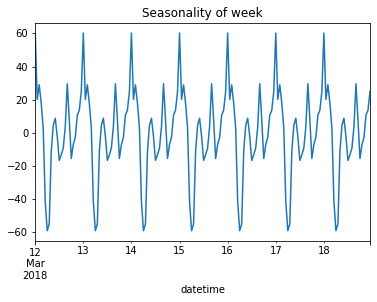

In [13]:
decomposed.seasonal['2018-03-12':'2018-03-18'].plot(ax=plt.gca())
plt.title('Seasonality of week');

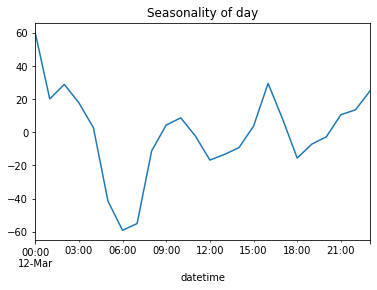

In [14]:
decomposed.seasonal['2018-03-12 00:00:00':'2018-03-12 23:00:00'].plot(ax=plt.gca())
plt.title('Seasonality of day');

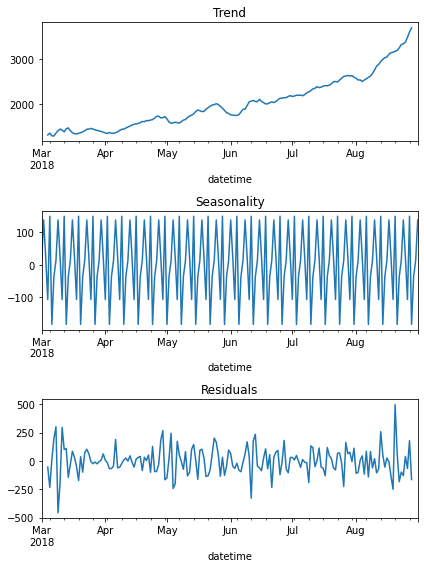

In [15]:
#Сделаем ресемплирование до 1 дня

taxi_day = taxi.resample('1D').sum()
decomposed2 = seasonal_decompose(taxi_day['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed2.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

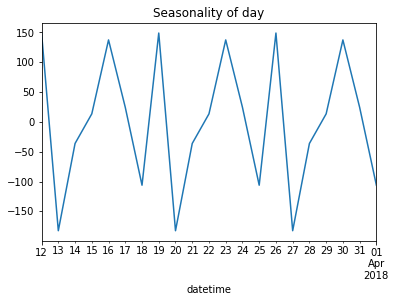

In [16]:
decomposed2.seasonal['2018-03-12':'2018-04-01'].plot(ax=plt.gca())
plt.title('Seasonality of day');

## Обучение

Для обучения нам понадобятся дополнительные признаки.

In [17]:
#Создадим функцию для удобного изменения добавляемых параметров на случай, если потребуется менять входные признаки при обучении

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    rolling_mean_size = rolling_mean_size
    data['rolling_sum'] = data['lag_1'].rolling(rolling_mean_size).sum()
    data['rolling_std'] = data['lag_1'].rolling(rolling_mean_size).std()
    
       
make_features(taxi, 24, 24)
display(taxi.head())

#При добавлении скользящего среднего b некоторых значений добавятся пустые значения
#т.к. там не будет достаточно данных для расчета. Проверим их наличие
print(taxi.isna().sum())
print('Размер до удаления пропусков: ', taxi.shape)   

#цдалим пустые значения
taxi = taxi.dropna()
print('Размер после удаления пропусков: ', taxi.shape)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_sum,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


num_orders      0
hour            0
dayofweek       0
lag_1           1
lag_2           2
lag_3           3
lag_4           4
lag_5           5
lag_6           6
lag_7           7
lag_8           8
lag_9           9
lag_10         10
lag_11         11
lag_12         12
lag_13         13
lag_14         14
lag_15         15
lag_16         16
lag_17         17
lag_18         18
lag_19         19
lag_20         20
lag_21         21
lag_22         22
lag_23         23
lag_24         24
rolling_sum    24
rolling_std    24
dtype: int64
Размер до удаления пропусков:  (4416, 29)
Размер после удаления пропусков:  (4392, 29)


Посмотрим, как дела с корреляцией у созданных признаков?

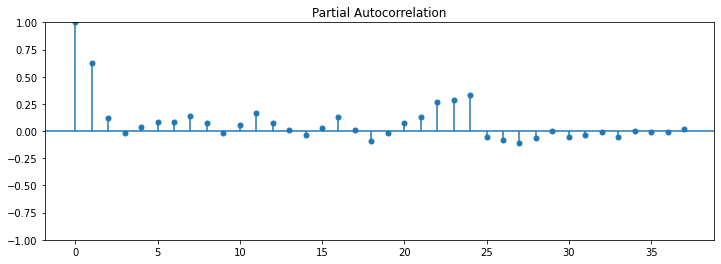

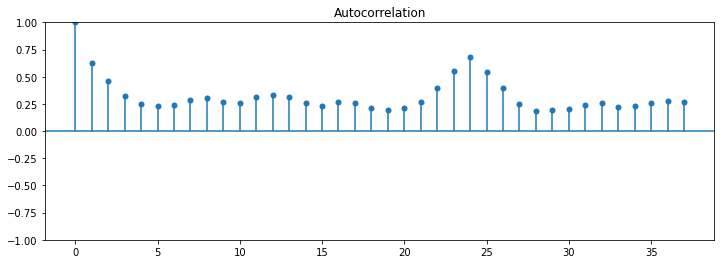

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(taxi.num_orders, alpha=None).set_size_inches(12, 4)
plt.show()

plot_acf(taxi.num_orders, alpha=None).set_size_inches(12, 4)
plt.show()


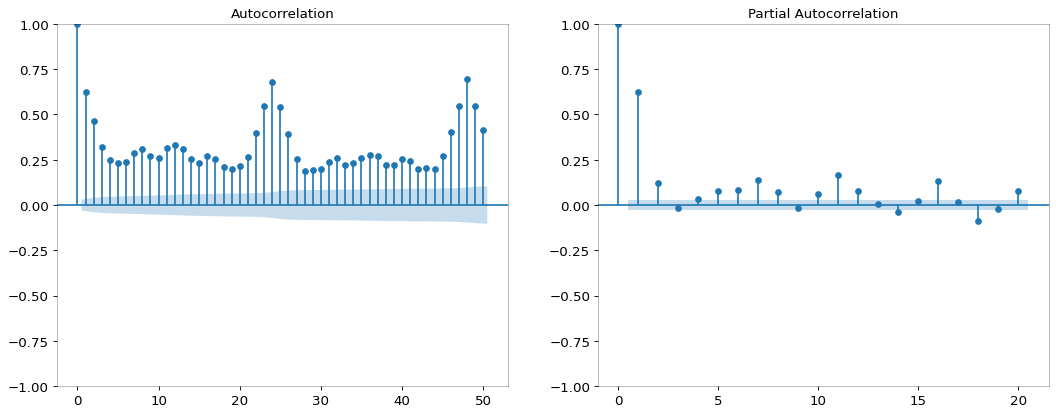

In [19]:
# Draw Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(taxi.num_orders.tolist(), ax=ax1, lags=50)
plot_pacf(taxi.num_orders.tolist(), ax=ax2, lags=20)

# Decorate
# lighten the borders
ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

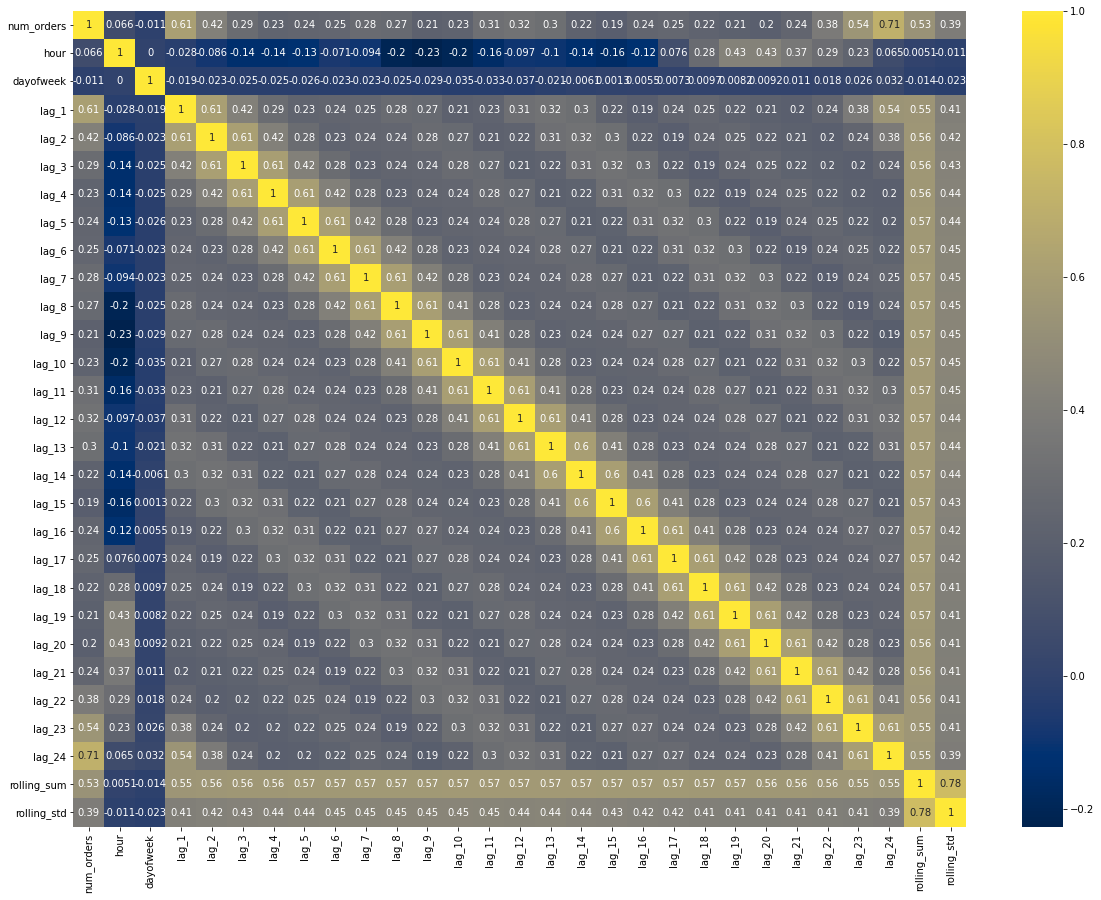

In [20]:
plt.figure(figsize=(20, 15))
sns.heatmap(taxi.corr(method='spearman'), annot=True, cmap='cividis');

Выводы:
1. С каждым месяцем становится все больше заказов такси - это тренд;
2. За каждый выделенный период видна сезонность:
* по дням, ожидаемо, меньше всего заказов такси в 5-6 утра, максимум - когда все едут с работы (около 18) и ночью, когда все едут домой из заведений (около 24);
* по неделям интересное наблюдение: больше всего заказывают такси в понедельник и пятницу, меньше всего - воскресенье (ожидаемо, люди проводят этот день дома) и во вторник (возможно, в командировку все уже прилетели: улетать рано, прилетать поздно). 
3. Целевой признак почти со всеми добавленными имеет хорошую корреляцию. Пока день недели и день показывают меньшую связь, чем прочие добавленные признаки.

In [21]:
#разделим на выборки
X = taxi.drop(['num_orders'], axis=1)
y = taxi['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    shuffle=False, 
    test_size=0.1
)

In [22]:
#проверим на корректность 
print(X_train.shape, X_test.shape)
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

(3952, 28) (440, 28)
2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [23]:
X_train.columns

Index(['hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_sum',
       'rolling_std'],
      dtype='object')

In [24]:
# создаём списки с названиями признаков
ord_columns = ['hour', 'dayofweek']
num_columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_sum',
       'rolling_std']

# создаём пайплайн для подготовки признаков из списка ord_columns
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder()),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 5),
        "models__max_features": range(2, 5),
        "models__min_samples_leaf": range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    
    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder()),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['hour', 'dayofweek']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                      

Попробуем lgbm - она должна работать быстрее.

In [ ]:
#попробуем LGBMRegressor
lgb_model = LGBMRegressor(verbose=-1)

lgbm_params =  {
    'max_depth': distributions.IntDistribution(1, 10),
    'n_estimators ': distributions.IntDistribution(100, 500),
    'num_leaves':  distributions.IntDistribution(31, 100)
} 

oscv_all_add = OptunaSearchCV(
    lgb_model, 
    lgbm_params, 
    cv=tscv,
    n_trials=25,
    error_score='raise',
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE
) 

oscv_all_add.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', oscv_all_add.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -oscv_all_add.best_score_)

[I 2024-02-18 14:10:30,819] A new study created in memory with name: no-name-8dc0d039-4729-43b1-9ddb-952c27f49a0d


[LightGBM] [Warning] Unknown parameter: 331
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 331
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 331
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 331
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Unknown parameter: 331
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100


[I 2024-02-18 14:11:34,596] Trial 0 finished with value: -27.48239948664318 and parameters: {'max_depth': 1, 'n_estimators ': 331, 'num_leaves': 36}. Best is trial 0 with value: -27.48239948664318.


[LightGBM] [Warning] Unknown parameter: 140
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100


In [ ]:
#попробуем найденную на просторах великого новую модель 
model2 = HistGradientBoostingRegressor().fit(X_train, y_train)

In [ ]:
scores_list = cross_val_score(estimator=model2, 
                              X=X_train, 
                              y=y_train, 
                              cv=tscv,  
                              scoring='neg_root_mean_squared_error')

val_score = -scores_list.mean()
print(f'Метрика rmse на тренировочной выборке: {val_score}')

## Тестирование

In [ ]:
df = pd.DataFrame({'Модель': ['DecisionTreeRegressor', 'LGBMRegressor', 'HistGradientBoostingRegressor'],
                   'best_score_ на обучении': [32, 25, 25]               
                  })

df

In [ ]:
y_test_pred5 = model2.predict(X_test)
print(f'Метрика rmse на тестовой выборке: {mean_squared_error(y_test, y_test_pred5, squared=False)}')

Для сравнения представлены три варианта:
1. DecisionTreeRegressor
2. LGBMRegressor
3. HistGradientBoostingRegressor

HistGradientBoostingRegressor и LGBMRegressor показали лучшее качество на кросс-валидации, при этом HistGradientBoostingRegressor работает значительно быстрее. Результат на тестовых данных удовлетворяет требованиям заказчика. 

Общий вывод:
1. Данные загружены, типы данных приведены в порядок, установлены индексы;
2. Данные проанализированы:
* выявлен тренд: с каждым месяцем становится все больше заказов такси
* выявлена сезонность: 
* по дням, ожидаемо, меньше всего заказов такси в 5-6 утра, максимум - когда все едут с работы (около 18) и ночью, когда все едут домой из заведений (около 24);
* по неделям интересное наблюдение: больше всего заказывают такси в понедельник и пятницу, меньше всего - воскресенье (ожидаемо, люди проводят этот день дома) и во вторник (возможно, в командировку все уже прилетели: улетать рано, прилетать поздно). 
3. Проверена корреляция признаков: целевой признак почти со всеми добавленными имеет хорошую корреляцию. Пока день недели и день показывают меньшую связь, чем прочие добавленные признаки.
4. Обучено несколько моделей. Предлагаем остановиться на HistGradientBoostingRegressor - модель показывает одно из лучших качеств на кросс-валидации и rmse на тестовых удовлетворяет требованиям заказчика: 41. 
